In [96]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
pd.set_option('display.float_format', lambda x: '%.3f' % x)


In [2]:
df = pd.read_csv('FoodFacts.csv')

//anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0,3,5,27,36) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.columns[[0, 3, 5, 27, 36]]

Index(['code', 'created_t', 'last_modified_t', 'cities', 'allergens_en'], dtype='object')

In [4]:
# Don't need code column
df.drop(['code', 'created_t', 'last_modified_datetime'], axis=1, inplace=True)

In [5]:
df.dtypes

url                                  object
creator                              object
created_datetime                     object
last_modified_t                      object
product_name                         object
generic_name                         object
quantity                             object
packaging                            object
packaging_tags                       object
brands                               object
brands_tags                          object
categories                           object
categories_tags                      object
categories_en                        object
origins                              object
origins_tags                         object
manufacturing_places                 object
manufacturing_places_tags            object
labels                               object
labels_tags                          object
labels_en                            object
emb_codes                            object
emb_codes_tags                  

In [52]:

#https://www.kaggle.com/christinampoid/d/openfoodfacts/world-food-facts/europe-habits

#labels: list of Strings with country names
#returns the rows that have as country name any of the names in labels
def get_rows_country(labels):
    return df[df.countries.isin(labels)]

#labels: list of Strings with country names
#returns the categories and the percentage that appear in the rows of a particular country
def get_categories_counts(labels):
    rows = get_rows_country(labels)
    food_country = rows.main_category_en.value_counts() / len(rows)*100
    return food_country

#France
labels_france = ['France', 'en:FR', 'France,Europe','Belgique,France']
french_food = get_rows_country(labels_france)

#Spain
labels_spain = ['España','en:ES','Espagne','Spain']
spanish_food = get_rows_country(labels_spain)

#Germany
labels_germany = ['Deutschland','Germany','Allemagne','en:DE']
german_food = get_rows_country(labels_germany)

#United Kingdom
labels_uk = ['en:UK','United Kingdom','en:GB','uk','UK']
uk_food = get_rows_country(labels_uk)

#Belgium
labels_belgium = ['Belgique','en:BE','Belgique,France','Belgium','Belgique,France']
belgium_food = get_rows_country(labels_belgium)

#Italia
labels_italia = ['Italia','en:IT','Italie']
italian_food = get_rows_country(labels_italia)

#Switzerland
labels_switzerland = ['Suisse','Switzerland']
suisse_food = get_rows_country(labels_switzerland)

#Netherlands
labels_netherlands = ['Netherlands', 'Holland']
holland_food = get_rows_country(labels_netherlands)

#Denmark
labels_denmark = ['Denmark','Dänemark']
dannish_food = get_rows_country(labels_denmark)

#Portugal
labels_portugal = ['Portugal','en:portugal']
portuguese_food = get_rows_country(labels_portugal)

#Greece
labels_greece = ['Greece','en:GR','Grèce','en:greece']
greek_food = get_rows_country(labels_greece)

#Sweden
labels_sweden = ['Sweden','en:SE','en:sweden']
swedish_food = get_rows_country(labels_sweden)

#Norway
labels_norway = ['Norway','en:NO','en:norway']
norwegian_food = get_rows_country(labels_norway)

#Croatia
labels_croatia = ['Croatia','en:HR','en:croatia']
croatian_food = get_rows_country(labels_croatia)

#Albania
labels_albania = ['Albania','en:AL','en:albania']
albanian_food = get_rows_country(labels_albania)

labels_usa = ['United States', 'en:US', 'US', 'USA', 'en:united-states','United states', 'united states', 'United States of America']
usa = get_rows_country(labels_usa)

In [53]:
europe = pd.concat([french_food,
                    spanish_food,
                    german_food, 
                    uk_food, 
                    belgium_food, 
                    italian_food, 
                    suisse_food,
                    holland_food,
                    dannish_food, 
                    portuguese_food, 
                    greek_food, 
                    swedish_food,
                    norwegian_food,
                    croatian_food, 
                    albanian_food])

In [54]:
mask = df.countries.str.contains('US', na=False)
df[mask].countries.unique()

array(['en:US', 'US', 'USA', 'France,USA', 'Germany,USA,UK'], dtype=object)

In [55]:
usaNumOnly = usa.select_dtypes(include=[np.number])
europeNumOnly = europe.select_dtypes(include=[np.number])

In [56]:
usaMeans = usaNumOnly.mean()
usaNaCols  = usaMeans[usaMeans.isnull() == True].index.tolist()

euroMeans = europeNumOnly.mean()
euroNaCols  = euroMeans[euroMeans.isnull() == True].index.tolist()
combinedNaCols = usaNaCols + euroNaCols
#usaNumOnly.columns[usaNumOnly.mean().isnull().astype(int).values]

In [57]:
usaNumOnly = usaNumOnly.drop(combinedNaCols, axis=1)
europeNumOnly = europeNumOnly.drop(combinedNaCols, axis=1)
print(europeNumOnly.shape)
print(usaNumOnly.shape)

(55942, 53)
(2413, 53)


In [105]:
usaNumOnly['isUS'] = 1
europeNumOnly['isUS'] = 0
train = pd.concat([usaNumOnly, europeNumOnly])

In [106]:
train = train.fillna(0, axis=0)

In [107]:
train.head()

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,energy_from_fat_100g,fat_100g,saturated_fat_100g,monounsaturated_fat_100g,polyunsaturated_fat_100g,omega_3_fat_100g,...,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,fruits_vegetables_nuts_100g,cocoa_100g,carbon_footprint_100g,nutrition_score_fr_100g,nutrition_score_uk_100g,isUS
20,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1
56,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1
78,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1
83,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1
87,3.000,0.000,0.000,761.000,275.000,7.580,4.040,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,4.000,1


### Fit various models to assess the predictive power of each ingredient in distinguishing Euro foods from USA foods

In [98]:
def makeTrainingSet(colsToDrop=[]):
    X = train.drop(['isUS'] + colsToDrop, axis=1)
    y = train['isUS']
    return (X, y)

def makeCoefDf(clf, X):
    coef_df = pd.DataFrame({'value': clf.coef_[0], 'absVal': abs(clf.coef_[0]), 'feature': X.columns })
    return coef_df.sort_values(by='absVal', ascending=False)

def makeFeatureImpDf(clf, X):
    coef_df = pd.DataFrame({'value': clf.feature_importances_[0], 'feature': X.columns })
    return coef_df.sort_values(by='value', ascending=False)

In [62]:
from sklearn.linear_model import LogisticRegression
(X, y) = makeTrainingSet(colsToDrop = [])
clf = LogisticRegression()
clf.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [17]:
lr_coef_one = makeCoefDf(clf, X)

In [18]:
lr_coef_one.iloc[0:10, :]

,absVal,feature,value
1,2.581829,ingredients_from_palm_oil_n,-2.581829
2,1.674912,ingredients_that_may_be_from_palm_oil_n,-1.674912
12,1.403766,cholesterol_100g,1.403766
9,0.789836,omega_3_fat_100g,-0.789836
31,0.527780,vitamin_b9_100g,0.527780
40,0.525608,zinc_100g,0.525608
15,0.272554,lactose_100g,-0.272554
10,0.222238,alpha_linolenic_acid_100g,-0.222238
39,0.173613,magnesium_100g,-0.173613
38,0.169477,iron_100g,0.169477


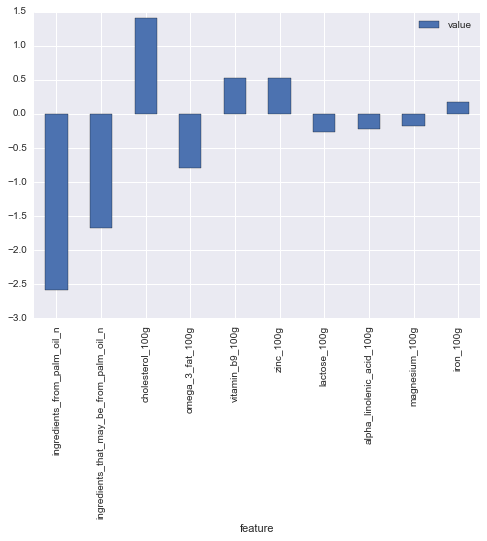

In [19]:
lr_coef_one.iloc[0:10, :].plot(kind='bar', x='feature', y='value')

It seems like many palm oil may indicate that a product is European. But that doesn't mean that European products are more likely to contain it than US products. In Europe, palm oil is required on food labels. In the US, it isn't:

- https://www.theguardian.com/sustainable-business/2014/dec/12/eu-labelling-changes-palm-oil-consumer-change
- http://www.eurofoodlaw.com/labelling/analysis-palm-oil-no-longer-a-hidden-ingredient-108325.htm


Now let's try a random forest.

In [63]:
from sklearn.ensemble import RandomForestClassifier as rf
clf = rf(max_depth=5)
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [64]:
importances_1_df = makeFeatureImpDf(clf, X)

In [65]:
importances_df.iloc[0:10, :]

NameError: name 'importances_df' is not defined

In [ ]:
importances_df.iloc[0:10, :].plot(kind='bar', x='feature', y='value')

hmm..it looks like palm oil isn't very important to our random forest. Let's remove palm oil, and see what happes. We'll also drop uk_nutrition_score and france_nutrition_score, as US products wouldn't have those on their labels.

In [108]:
colsToDrop = ['ingredients_from_palm_oil_n', 
              'ingredients_that_may_be_from_palm_oil_n', 
              'nutrition_score_uk_100g',
              'nutrition_score_fr_100g']
train = train.drop(colsToDrop, axis=1)

clf = LogisticRegression()
(X, y) = makeTrainingSet()
clf.fit(X,y)
coef_wo_palm_df = makeCoefDf(clf, X)
coef_wo_palm_df.iloc[0:10, :]

,absVal,feature,value
0,0.084,additives_n,-0.084
6,0.081,polyunsaturated_fat_100g,0.081
30,0.078,vitamin_b12_100g,0.078
46,0.066,fruits_vegetables_nuts_100g,-0.066
14,0.065,polyols_100g,-0.065
33,0.063,potassium_100g,0.063
4,0.055,saturated_fat_100g,0.055
2,0.054,energy_from_fat_100g,0.054
47,0.051,cocoa_100g,-0.051
16,0.047,proteins_100g,-0.047


In [ ]:
from sklearn.ensemble import RandomForestClassifier as rf
clf = rf(max_depth=5)
clf.fit(X, y)

In [ ]:
importances_wo_palm_df = makeFeatureImpDf(clf, X) 
importances_wo_palm_df

Without palm oil, the random forest has gone haywire

Let's look at correlation coeffiecients.

In [117]:
corr_df = pd.DataFrame({'feature': [], 'pval': [], 'value': []})

from scipy.stats import pointbiserialr
(X, y) = makeTrainingSet()


for col in train.drop(['isUS'], axis= 1).columns:
    corr = pointbiserialr(train['isUS'].values, train[col].values)
    corr_df = corr_df.append(pd.Series({'feature': col, 'pval':corr.pvalue, 'value': corr.correlation, 'absVal': abs(corr.correlation)}), ignore_index=True)

corr_df.sort_values(by='absVal', ascending=False, inplace=True)
corr_df.iloc[0:10, :]

,feature,pval,value,absVal
2,energy_from_fat_100g,0.000,0.340,0.340
10,cholesterol_100g,0.000,0.199,0.199
9,trans_fat_100g,0.000,0.039,0.039
16,proteins_100g,0.000,-0.037,0.037
0,additives_n,0.000,-0.031,0.031
6,polyunsaturated_fat_100g,0.000,0.025,0.025
46,fruits_vegetables_nuts_100g,0.000,-0.022,0.022
42,chromium_100g,0.000,0.021,0.021
38,zinc_100g,0.000,0.021,0.021
1,energy_100g,0.000,-0.021,0.021


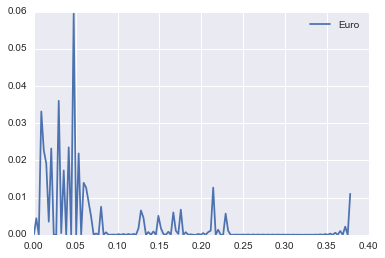

In [142]:
us = train[train['isUS'] == 1]
euro = train[train['isUS'] == 0]
#sns.kdeplot(us['cholesterol_100g'], label='US')
sns.kdeplot(euro['cholesterol_100g'], label='Euro')

In [140]:
sns.kdeplot(us['cholesterol'], label='US')
sns.kdeplot(euro['cholesterol'], label='Euro')

KeyError: 'cholesterol'

In [137]:
euro['energy_from_fat_100g'].max()

1420.0

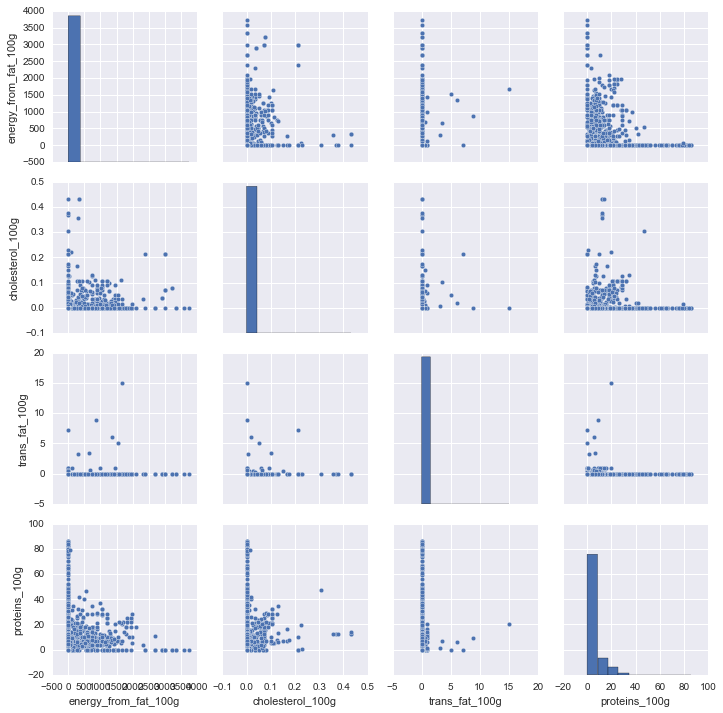

In [120]:
top_features = corr_df.iloc[0:4, :]['feature']
g = sns.pairplot(train[top_features])

In [ ]:
(X, y) = makeTrainingSet()
(Xtrain, Xtest, yTrain, yTest) = cross_validation.train_test_split(X, y)
clf = LogisticRegression(class_weight='balanced')
clf.fit(Xtrain, yTrain)
print('F1 Score: {}'.format(f1_score(yTest.values, clf.predict(Xtest.values))))
print('AUC: {}'.format(roc_auc_score(clf.predict(Xtest.values), yTest.values)))
print('Precision: {}'.format(precision_score(y_true=yTest.values,y_pred= clf.predict(Xtest.values))))
print('Recall: {}'.format(recall_score(y_true=yTest.values,y_pred= clf.predict(Xtest.values))))
print('Accuracy: {}'.format(accuracy_score(y_true=yTest.values,y_pred= clf.predict(Xtest.values))))

We might as well be guessing randomly. Particularly, the precision score indicates we're making many false positive errors, predicting European foods as US foods.

In [ ]:
(Xtrain, Xtest, yTrain, yTest) = cross_validation.train_test_split(X, y)
clf = rf(class_weight='balanced', max_depth=5)
clf.fit(Xtrain, yTrain)
print('F1 Score: {}'.format(f1_score(yTest.values, clf.predict(Xtest.values))))
print('AUC: {}'.format(roc_auc_score(clf.predict(Xtest.values), yTest.values)))
print('Precision: {}'.format(precision_score(y_true=yTest.values,y_pred= clf.predict(Xtest.values))))
print('Recall: {}'.format(recall_score(ytrue=yTest.values,y_pred= clf.predict(Xtest.values))))
print('Accuracy: {}'.format(accuracy_score(y_true=yTest.values,y_pred= clf.predict(Xtest.values))))

In [ ]:
plt.scatter(train.energy_from_fat_100g, train.cholesterol_100g, c=train.isEuro)
plt.xlabel('energy from fat')
plt.ylabel('cholesterol')
plt.legend(loc='best')

In [109]:
X = train.drop(['isUS'], axis=1).values
y = train['isUS'].values
skf = cross_validation.StratifiedKFold(y, n_folds=5)
scores = []
clf = LogisticRegression()
for train_i, test_i in skf:    
    clf.fit(X[train_i], y[train_i])
    preds = clf.predict(X[test_i])
    scores.append(accuracy_score(y_true=y[test_i],y_pred= preds))
    print('AUC: {}'.format(roc_auc_score(preds, y[test_i])))

print('Avg acc.: {}, Std: {}'.format(np.mean(scores), np.std(scores)))



AUC: 0.9767249220374221
AUC: 0.98399515529025
AUC: 0.9644384608417118
AUC: 0.9506822481728231
AUC: 0.9741364919007409
Avg acc.: 0.9668236158998245, Std: 0.0018634463432022122


In [110]:
strat_df = makeCoefDf(clf, train.drop(['isUS'], axis=1))
strat_df.iloc[0:10, :]

,absVal,feature,value
7,0.607,omega_3_fat_100g,-0.607
10,0.538,cholesterol_100g,0.538
35,0.520,phosphorus_100g,0.520
8,0.226,alpha_linolenic_acid_100g,-0.226
38,0.177,zinc_100g,0.177
29,0.172,vitamin_b9_100g,0.172
13,0.160,lactose_100g,-0.160
48,0.139,carbon_footprint_100g,-0.139
30,0.135,vitamin_b12_100g,0.135
9,0.103,trans_fat_100g,-0.103


### Let's explore the how US and Euro foods differ within food categories